## Visualise school traffic

In [17]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'LCA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
health_paths = pd.read_parquet(join(resultsdir, f"transport/path and flux data/health/{COUNTRY}_health_pathdata_time_m_60.parquet"))

loading config file from ../../...
Number of nodes: 8,275
Number of edges: 9,263


In [18]:
from shapely.geometry import MultiLineString

def get_multilinestring(path, edge_geoms):
    linestrings = [edge_geoms.loc[edge].geometry for edge in path]
    return MultiLineString(linestrings)


edge_geoms = roads[['edge_id', 'geometry']].set_index('edge_id')
health = gpd.read_file(join(datadir, 'infrastructure', 'social', f'{COUNTRY.lower()}_health.gpkg'))
health_paths['geometry'] = health_paths['edge_path'].apply(lambda path: get_multilinestring(path, edge_geoms))
health_paths = gpd.GeoDataFrame(health_paths, geometry='geometry').set_crs(caribbean_epsg)
health_paths.head()

,origin_id,destination_id,edge_path,time_m,flux,geometry
0,roadn_10004,LCA_health_12_and_LCA_health_22,"[roade_18593, roade_18592, roade_18591, roade_...",28.085853,1.214724e-06,"MULTILINESTRING ((719356.582 1520852.398, 7194..."
1,roadn_10004,LCA_health_13,"[roade_4348, roade_3553, roade_3554, roade_355...",56.698472,2.223961e-06,"MULTILINESTRING ((719432.842 1521028.839, 7194..."
2,roadn_10004,LCA_health_14,"[roade_4348, roade_3553, roade_3554, roade_355...",57.092754,2.881526e-06,"MULTILINESTRING ((719432.842 1521028.839, 7194..."
3,roadn_10004,LCA_health_26,"[roade_4348, roade_3553, roade_3554, roade_355...",55.150955,1.277098e-07,"MULTILINESTRING ((719432.842 1521028.839, 7194..."
4,roadn_10004,LCA_health_30,"[roade_4348, roade_3553, roade_3554, roade_355...",34.174449,6.250947e-07,"MULTILINESTRING ((719432.842 1521028.839, 7194..."


In [19]:
health_paths.shape
# LCA: (84,212, 6)
# VCT: (52,406, 6)
# GRD: (26,191, 6)

(84212, 6)

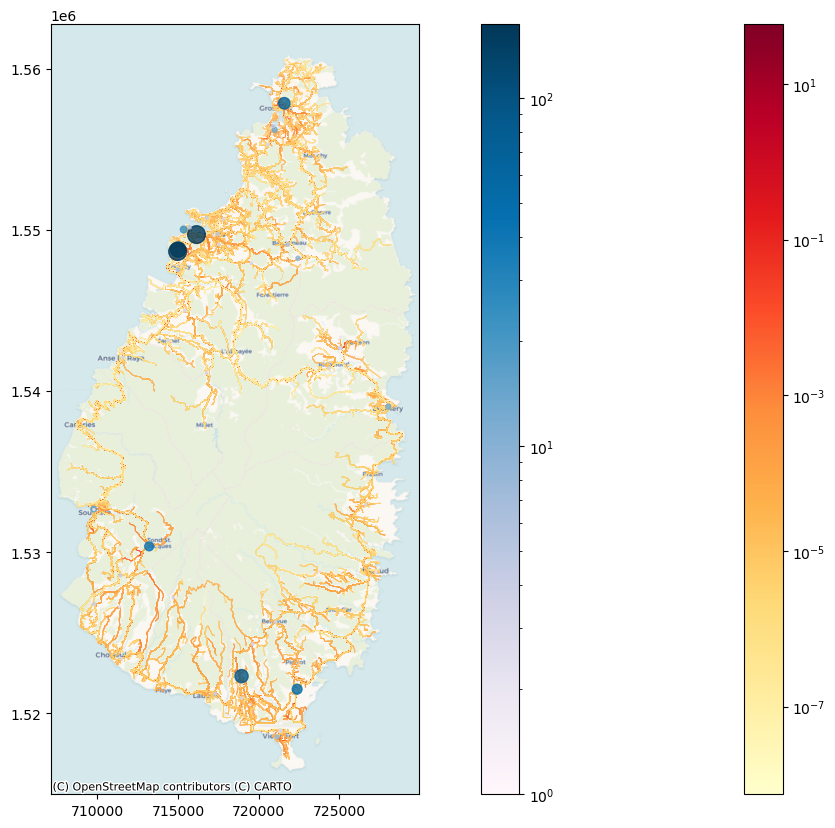

In [20]:
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_buildings(buildings_gdf, col: str, **kwargs):
    import matplotlib.colors as colors
    buildings_gdf.set_geometry(buildings_gdf.centroid).plot(col, markersize=buildings_gdf[col],
                                          cmap='PuBu', legend=True, alpha=.8,
                                          norm=colors.LogNorm(buildings_gdf[col].min(), buildings_gdf[col].max()),
                                          **kwargs)


vmin = health_paths['flux'].min()
vmax = health_paths['flux'].max()

fig, ax = plt.subplots(figsize=(20, 10))

# roads.plot(color='black', linewidth=.2, alpha=.8, linestyle='--', ax=ax, zorder=1)
health_paths.plot('flux', linewidth=.5, alpha=.5, norm=colors.LogNorm(vmin, vmax),
                            ax=ax, cmap="YlOrRd", zorder=2, legend=True)
plot_buildings(health, 'bed_capacity',  ax=ax, zorder=3)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=health_paths.crs, zoom=12)

fig.savefig(os.path.join(figdir, f"{COUNTRY}_health_routes.png"), **plot_kwargs)

In [21]:
!say done

# Checking results

In [101]:
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from geospatial_utils import load_config
from analysis_utils import get_nearest_values
import transport_flow_and_disruption_functions as tfdf


# global settings
COUNTRY = 'DMA'
COST = 'time_m'
THRESH = 60
TRUNC_THRESH = 1
ZETA = 1
RECALCULATE_PATHS = True
RECALCULATE_TRAFFIC = False
EDGE_ATTRS = ['edge_id', 'length_m', 'time_m']
plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}
caribbean_epsg = 32620


datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads
roads, road_net = tfdf.get_roads(os.path.join(datadir, 'infrastructure', 'transport'), COUNTRY, EDGE_ATTRS)

# load health data
health = gpd.read_file(os.path.join(datadir, 'infrastructure', 'social', f'{COUNTRY.lower()}_health.gpkg'))
health = health[health['iso_code'] == COUNTRY].copy()
health = health.to_crs(caribbean_epsg)

Number of nodes: 7,613
Number of edges: 8,336


In [114]:
# get all node geometries
roads = roads.to_crs(caribbean_epsg)
node_geoms = {node: Point(line.coords[-1]) for node, line in zip(roads['to_node'], roads['geometry'])}
node_geoms = node_geoms | {node: Point(line.coords[0]) for node, line in zip(roads['from_node'], roads['geometry']) if node not in node_geoms.keys()}
nodes_gdf = gpd.GeoDataFrame.from_dict(node_geoms, orient='index').reset_index().rename(columns={'index': 'node', 0: 'geometry'}).set_geometry('geometry')
nodes_gdf = nodes_gdf.set_crs(caribbean_epsg)

/Users/alison/mambaforge/envs/general/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


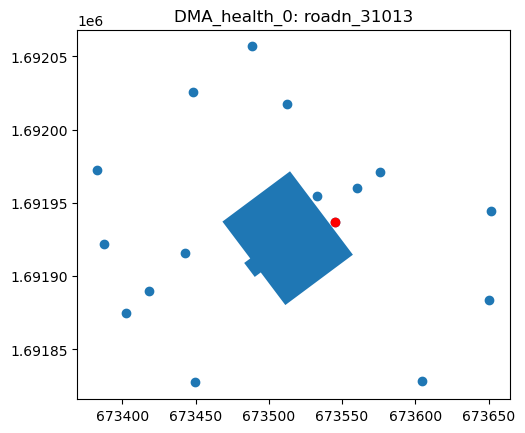

In [115]:
# find nearest nodes to each school building
health['nearest_node'] = health.apply(lambda row: get_nearest_values(row, nodes_gdf, 'node'), axis=1)
aggfunc = {'node_id': lambda x : '_and_'.join(x), 'bed_capacity': sum}
nearest_nodes = health[['nearest_node', 'node_id', 'bed_capacity']].groupby('nearest_node').agg(aggfunc).reset_index()
tfdf.test_plot(nodes_gdf, health, **{'aspect': 1})

In [117]:
# replace nodes with health in road network
rename_health = {node_id: hospital_id for node_id, hospital_id in zip(nearest_nodes['nearest_node'], nearest_nodes['node_id'])}
hospital_pops = {hospital_id: hospital_pop for hospital_id, hospital_pop in zip(nearest_nodes['node_id'], nearest_nodes['bed_capacity'])}
hospital_classes = {hospital_id: "hospital" for hospital_id in nearest_nodes['node_id']}
road_net = nx.relabel_nodes(road_net, rename_health, copy=True)
nx.set_node_attributes(road_net, hospital_pops, name="population")
nx.set_node_attributes(road_net, "domestic", name="class")
nx.set_node_attributes(road_net, hospital_classes, name="class")
tfdf.test_pop_assignment(road_net, nearest_nodes, rename_health, 'bed_capacity')

In [118]:
paths_df = tfdf.get_flux_data(road_net, COST, THRESH, ZETA, origin_class='domestic', dest_class='hospital', class_str='class', thresh=TRUNC_THRESH)

processing paths from source nodes: 100%|███████████████████████████████████████████████████████████| 7613/7613 [01:58<00:00, 64.18it/s]


Function get_flux_data(<networkx.classes.graph.Graph object at 0x1626ee280>, 'time_m', 60, 1) kwargs: {'origin_class': 'domestic', 'dest_class': 'hospital', 'class_str': 'class', 'thresh': 1} Took 118.6760 seconds.



In [119]:
paths_df.head()

,origin_id,destination_id,edge_path,time_m,flux
0,roadn_10,DMA_health_0_and_DMA_health_1,"[roade_4695, roade_4694, roade_35333, roade_33...",7.855652,0.000046
1,roadn_10,DMA_health_12,"[roade_4695, roade_4694, roade_35333, roade_33...",7.250348,0.000427
2,roadn_10,DMA_health_2,"[roade_4696, roade_4697, roade_4698, roade_469...",27.794408,0.000002
3,roadn_10025,DMA_health_0_and_DMA_health_1,"[roade_5901, roade_5902, roade_5903, roade_590...",45.065137,0.000001
4,roadn_10025,DMA_health_12,"[roade_5901, roade_5902, roade_5903, roade_590...",44.459834,0.000009


In [120]:
pathname = os.path.join(resultsdir, 'transport', 'path and flux data','health', f'{COUNTRY}_health_pathdata_{COST}_{THRESH}')
paths_df.to_parquet(path=f"{pathname}.parquet", index=True)

In [91]:
pathname

'/Users/alison/Documents/World Bank Caribbean/data/results/transport/path and flux data/health/LCA_health_pathdata_time_m_60'

In [121]:
pd.read_parquet(f"{pathname}.parquet")

,origin_id,destination_id,edge_path,time_m,flux
0,roadn_10,DMA_health_0_and_DMA_health_1,"[roade_4695, roade_4694, roade_35333, roade_33...",7.855652,0.000046
1,roadn_10,DMA_health_12,"[roade_4695, roade_4694, roade_35333, roade_33...",7.250348,0.000427
2,roadn_10,DMA_health_2,"[roade_4696, roade_4697, roade_4698, roade_469...",27.794408,0.000002
3,roadn_10025,DMA_health_0_and_DMA_health_1,"[roade_5901, roade_5902, roade_5903, roade_590...",45.065137,0.000001
4,roadn_10025,DMA_health_12,"[roade_5901, roade_5902, roade_5903, roade_590...",44.459834,0.000009
...,...,...,...,...,...
11754,roadn_9970,DMA_health_12,"[roade_18551, roade_7004, roade_7003, roade_70...",33.544368,0.000014
11755,roadn_9970,DMA_health_2,"[roade_18551, roade_7005, roade_7006, roade_70...",2.084624,0.000036
11756,roadn_9971,DMA_health_0_and_DMA_health_1,"[roade_7004, roade_7003, roade_7002, roade_700...",33.857553,0.000007
11757,roadn_9971,DMA_health_12,"[roade_7004, roade_7003, roade_7002, roade_700...",33.252250,0.000052


In [72]:
health_paths['destination_id'].unique()

array(['DMA_health_0_and_DMA_health_1_and_DMA_health_2_and_DMA_health_3_and_DMA_health_4_and_DMA_health_5_and_DMA_health_6_and_DMA_health_7_and_DMA_health_8_and_DMA_health_9_and_DMA_health_10_and_DMA_health_11_and_DMA_health_12_and_DMA_health_13_and_DMA_health_14'],
      dtype=object)

In [70]:
health.sort_values(by='bed_capacity', ascending=False)[['node_id', 'bed_capacity']]

,node_id,bed_capacity
12,DMA_health_12,224.0
0,DMA_health_0,23.0
1,DMA_health_1,10.0
2,DMA_health_2,7.0
8,DMA_health_8,3.0
14,DMA_health_14,3.0
6,DMA_health_6,2.0
7,DMA_health_7,2.0
9,DMA_health_9,2.0
3,DMA_health_3,1.0


## Visualise school traffic disruption

In [97]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'DMA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]

disruption_df = pd.read_parquet(join(resultsdir, "transport/disruption results/lca_schools_roads_edges_sector_damages_with_rerouting.parquet"))
disruption_df = disruption_df[['hazard', 'rcp', 'rp', 'trips_lost_mean', '%trips_lost_mean', 'time_m_delta_mean',
               '%time_m_delta_mean', '%time_m_delta_amax', 'rerouting_loss_person_time_m_mean', '%time_m_delta_total_mean']]
              

loading config file from ../../...
Number of nodes: 7,613
Number of edges: 8,336


array([[<Axes: title={'center': 'rp'}>,
        <Axes: title={'center': 'trips_lost_mean'}>,
        <Axes: title={'center': '%trips_lost_mean'}>],
       [<Axes: title={'center': 'time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_amax'}>],
       [<Axes: title={'center': 'rerouting_loss_person_time_m_mean'}>,
        <Axes: title={'center': '%time_m_delta_total_mean'}>, <Axes: >]],
      dtype=object)

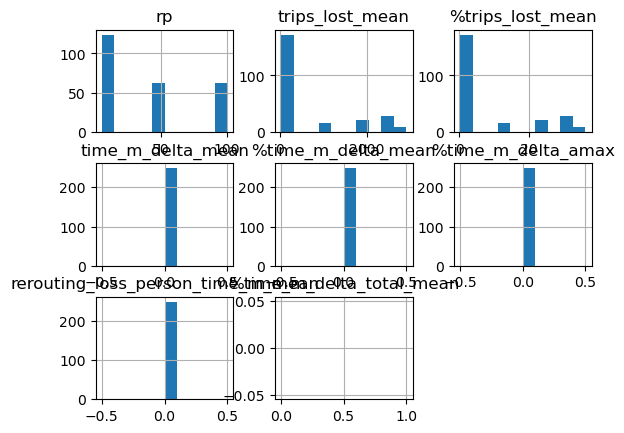

In [148]:
disruption_df.hist()